<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/BraTs2020_trial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset information

    1. Multimocel scans available as Nifti files (.nii.gz)
    2. Four channels of information
        1. Native (T1)
        2. Post-contrast T1-weight(T1CE)
        3. T2-weighted (T2)
        4. T2 Fluid Attenuated Inversion Recovery (FLAIR) volumns
    3. All the imaging datasets havre been segmented manually and were approved by experienced neuro-radiologists.
    4. Annotations (label):
        1. Label 0 : Unlabeled volumn
        2. Label 1 : Necrotic and non-enhancing tumor core (NCR/ NET)
        3. Label 2 : Peritumoral edema (ED)
        4. Label 3 : missing ( No pixels in all the volumnes contain label 3 )
        5. Label 4 : GD-enhancing tumor (ET) 

#### Kaggle

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

# DATASET DOWNLOAD

In [3]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [00:38<00:00, 159MB/s]
100% 4.16G/4.16G [00:38<00:00, 116MB/s]


# DATA UNPACK

In [5]:
import shutil
import os
# shutil.unpack_archive('/content/brats20-dataset-training-validation.zip','/content/brats20-dataset-training-validation')
# shutil.unpack_archive('/content/drive/MyDrive/Practice_notebook/VISION/Segment/Keras/BRAIN3D/dataset.zip',
#                       '/content/brats20')


os.rename(
    '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii',
    '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
    )
# os.rename(
#     '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii',
#     '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_35
5_seg.nii'
#     )

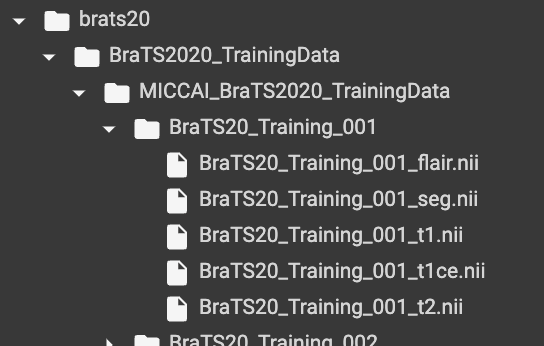

# MODUEL IMPORT

In [6]:
import numpy as np
import nibabel as nib
from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import cv2
import os 
import shutil


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# EDA

## PATH

In [7]:
%cd /content/brats20-dataset-training-validation

/content/brats20-dataset-training-validation


In [8]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [11]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
""" Scaling > covert 3d volumn to 1d > reconvert to 3d
    flatting it > 3d volumn """
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

1854.603271484375
[0 1 2 4]
[0 1 2 3]


### VISUALIZATION

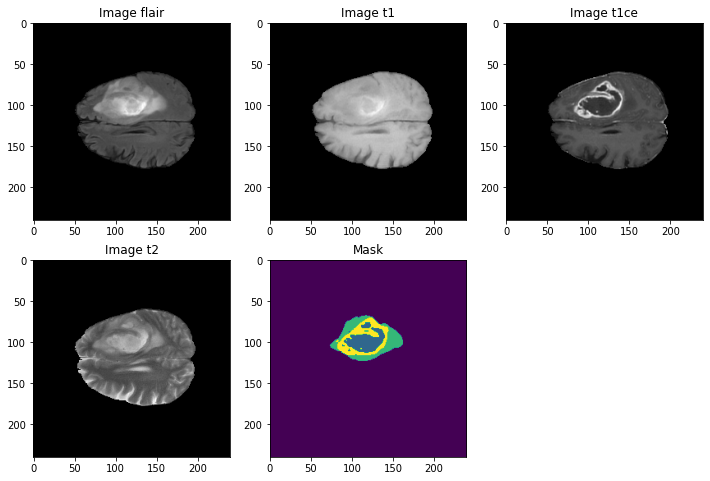

In [14]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# COMBINE

    combine image to single volumn to train

    * Explore the process of combining images to channels and divide them to patches.
    * Combining all 4 images to 4 channels of a np.array
    * Flair, TICE, and T2 have the most information
    * Combine TICE, T2 and FLAIR into single multichannel image

    * NOT RESHAPE  >> GET PROPER SEG

In [15]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x.shape

(240, 240, 155, 3)

In [16]:
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

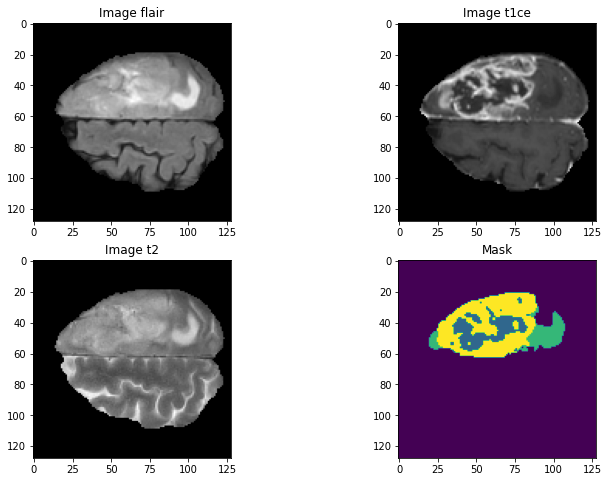

In [17]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [26]:
# imsave('BraTS2020_TrainingData/combined255.tif', combined_x)
# np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
# #Verify image is being read properly
# #my_img=imread('BraTS2020_TrainingData/combined255.tif')

# my_img=np.load('BraTS2020_TrainingData/combined255.npy')

# test_mask = to_categorical(test_mask, num_classes=4)

# FULL DATA

    * Merge channels, crop, patchify, save
    * get data ready > generators or otherwise
    * Keras Datagenerator does not support 3d

#### TRAINING DATA

In [19]:
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [20]:
len(mask_list)

369

In [23]:
if not os.path.exists('/content/bBraTS2020_TrainingData/input_data_3channels/images'):
    os.makedirs('/content/BraTS2020_TrainingData/input_data_3channels/images')

if not os.path.exists('/content/BraTS2020_TrainingData/input_data_3channels/masks'):
    os.makedirs('/content/BraTS2020_TrainingData/input_data_3channels/masks')

In [26]:
%pwd

'/content/brats20-dataset-training-validation'

In [27]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

Save Me
Now preparing image and masks number:  25
Save Me
Now preparing image and masks number:  26
Save Me
Now preparing image and masks number:  27
I am useless
Now preparing image and masks number:  28
Save Me
Now preparing image and masks number:  29
Save Me
Now preparing image and masks number:  30
Save Me
Now preparing image and masks number:  31
Save Me
Now preparing image and masks number:  32
Save Me
Now preparing image and masks number:  33
Save Me
Now preparing image and masks number:  34
Save Me
Now preparing image and masks number:  35
I am useless
Now preparing image and masks number:  36
Save Me
Now preparing image and masks number:  37
Save Me
Now preparing image and masks number:  38
Save Me
Now preparing image and masks number:  39
Save Me
Now preparing image and masks number:  40
Save Me
Now preparing image and masks number:  41
Save Me
Now preparing image and masks number:  42
Save Me
Now preparing image and masks number:  43
I am useless
Now preparing image and mas

### VALIDATION DATA

In [28]:
t2_list = sorted(glob(os.path.join('/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData','*/*t2.nii')))
t1ce_list = sorted(glob(os.path.join('/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData','*/*t1ce.nii')))
flair_list = sorted(glob(os.path.join('/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData','*/*flair.nii')))
mask_list = sorted(glob(os.path.join('/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData','*/*seg.nii')))

In [29]:
len(t2_list)

125

In [30]:
if not os.path.exists('/content/bBraTS2020_ValidationData/input_data_3channels/images/'):
    os.makedirs('/content/bBraTS2020_ValidationData/input_data_3channels/images/')

In [31]:
for img in tqdm(range(len(t2_list))):
    # print('Preparing image and mask number : ', img)
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    
    # condition loop for unique mask
    
    np.save(f'/content/bBraTS2020_ValidationData/input_data_3channels/images/image_{str(img)}.npy', temp_combined_images)

100%|██████████| 125/125 [02:30<00:00,  1.21s/it]


# SEPERATE

In [32]:
# !rm -rf /content/BraTS2020_TrainingData

In [56]:
!rm -rf /content/brats_custom
!rm -rf '/content/BraTS2020_TrainingData/input_data_128/'

In [58]:
# !pip install split-folders
import splitfolders
input_folder = '/content/BraTS2020_TrainingData/input_data_3channels'
output_folder = '/content/BraTS2020_TrainingData/input_data_128/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 3 files [00:00, 20.49 files/s]
Copying files: 6 files [00:00, 15.87 files/s]
Copying files: 8 files [00:00, 14.76 files/s]
Copying files: 10 files [00:00, 13.97 files/s]
Copying files: 12 files [00:00, 13.62 files/s]
Copying files: 14 files [00:01,  8.66 files/s]
Copying files: 16 files [00:03,  2.42 files/s]
Copying files: 17 files [00:03,  2.65 files/s]
Copying files: 18 files [00:03,  2.90 files/s]
Copying files: 19 files [00:04,  3.17 files/s]
Copying files: 20 files [00:04,  2.97 files/s]
Copying files: 21 files [00:04,  3.16 files/s]
Copying files: 22 files [00:04,  3.36 files/s]
Copying files: 23 files [00:06,  1.74 files/s]
Copying files: 24 files [00:06,  2.14 files/s]
Copying files: 25 files [00:06,  2.56 files/s]
Copying files: 26 files [00:06,  2.96 files/s]
Copying files: 27 files [00:07,  3.33 files/s]
Copying files: 28 files [00:07,  3.01 files/s]
Copying files: 29 files [00:07,  3.25 files/s]
Copying files: 30 fi

# DATA GENERATOR

In [ ]:
# KERAS DATAGENERATOR > DOESNT WORK WITH NPY

In [59]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [60]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [61]:
%cd /content

/content


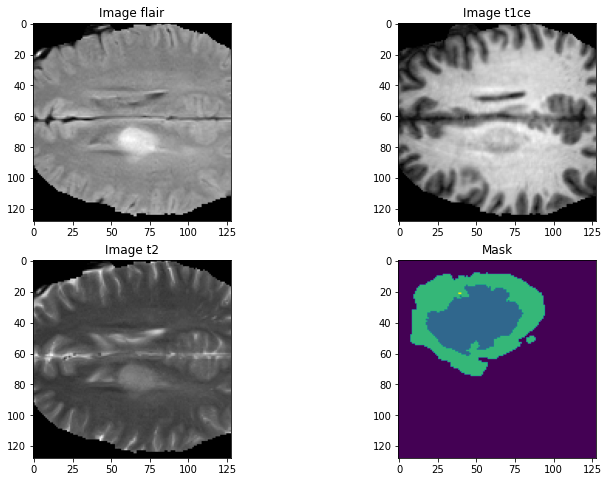

In [63]:
from matplotlib import pyplot as plt
import random

train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# UNET TRAINING

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

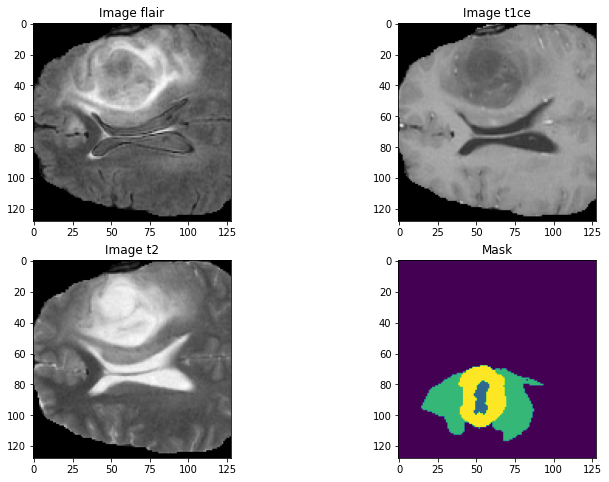

In [69]:
train_img_dir = "/content/brats_custom/input_data_128/train/images/"
train_mask_dir = "/content/brats_custom/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
mask_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0, num_images-1)
test_img = np.load(train_img_dir + img_list[img_num])
test_mask = np.load(train_mask_dir + mask_list[img_num])
test_mask = np.argmax(test_mask, axis = 3)                # np.array의 최대값 색인.


n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize = (12,8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
a

# DATA SAVE



```
dst = '/mnt/data' # where to save
src = '/home/abc' # directory to be zipped
path_to_archive = shutil.make_archive(dst,'zip',src)
# path_to_archive = '/mnt/data/abc.zip
```



In [24]:
# dst = '/content/drive/MyDrive/Practice_notebook/VISION/Segment/Keras/BRAIN3D/processed_train/dataset'
dst = '/content/processed_train'
src = '/content/brats_custom/input_data_3channels'
# shutil.copy(src, dst)
shutil.make_archive(dst,'zip',src)

KeyboardInterrupt: ignored

In [ ]:
# dst = '/content/drive/MyDrive/Practice_notebook/VISION/Segment/Keras/BRAIN3D/splited_train/dataset.zip'
dst = '/content/splited_train'
src = '/content/
brats_custom/input_data_128'
# shutil.copy(src, dst)
shutil.make_archive(dst,'zip',src)

In [ ]:
dst = '/content/processed_validation'
src = '/content/brats_validation/input_data_3channels'
# shutil.copy(src, dst)
shutil.make_archive(dst,'zip',src)